In [1]:
import numpy as np

import enum
import math

import matplotlib.pyplot as plt


import torch

import torch.nn as nn
import torch.nn.functional as F

from itertools import chain

import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
import copy
from torch.utils.data import DataLoader, Dataset
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

# #show if metal is available
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")
    
# # show python version
# !python -V

# torch.set_default_dtype(torch.float32)

2.1.1
11.8


In [3]:
import torch

if torch.cuda.is_available():
	num_gpus = torch.cuda.device_count()
	print(f"Number of available GPUs: {num_gpus}")
else:
	print("CUDA is not available. No GPUs detected.")

Number of available GPUs: 3


In [4]:
import torch

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available. No GPUs detected.")

GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB
GPU 2: Tesla V100-SXM2-32GB


## collecting and preparing data

In [5]:
%pwd

'/home/alinezhad.f'

In [6]:
#change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/cancer/')

# Cancer data preparation

In [7]:
tau=0
#read from pickle file
training_data = pd.read_pickle(f'training_data_tau_{tau}.pkl')
validation_data = pd.read_pickle(f'validation_data_tau_{tau}.pkl')

test_data_factuals = pd.read_pickle(f'test_data_factuals_tau_{tau}.pkl')
#:return: simulated data dict with number of rows equal to num_patients * seq_length * num_treatments
test_data_counterfactuals = pd.read_pickle(f'test_data_counterfactuals_tau_{tau}.pkl')
#:return: simulated data dict with number of rows equal to num_patients * seq_length * 2 * projection_horizon
test_data_seq = pd.read_pickle(f'test_data_seq_tau_{tau}.pkl')
means = pd.read_pickle(f'means_tau_{tau}.pkl')
stds = pd.read_pickle(f'stds_tau_{tau}.pkl')

In [8]:
training_data['patient_types']

array([2, 2, 1, ..., 2, 1, 1])

In [9]:
# import logging
# import pickle
# import pandas as pd

# # Set the file path
# tau = 0
# pickle_file_path = f'data/new_cancer_sim_{tau}_{tau}.p'

# # Read data from the pickle file
# with open(pickle_file_path, 'rb') as file:
#     pickle_map = pickle.load(file)

# # Extract the relevant data from the pickle map
# chemo_coeff = pickle_map['chemo_coeff']
# radio_coeff = pickle_map['radio_coeff']
# num_time_steps = pickle_map['num_time_steps']
# training_data = pickle_map['training_data']
# validation_data = pickle_map['validation_data']
# test_data_counterfactuals = pickle_map['test_data']
# test_data_factuals = pickle_map['test_data_factuals']
# test_data_seq = pickle_map['test_data_seq']
# scaling_data = pickle_map['scaling_data']
# means = pickle_map['scaling_data'][0]
# stds = pickle_map['scaling_data'][1]
# window_size = pickle_map['window_size']

# # Optional: Print the loaded data for verification
# print("Chemo Coeff:", chemo_coeff)
# print("Radio Coeff:", radio_coeff)
# print("Number of Time Steps:", num_time_steps)
# print("Training Data:", training_data)
# print("Validation Data:", validation_data)
# print("Test Data Counterfactuals:", test_data_counterfactuals)
# print("Test Data Factuals:", test_data_factuals)
# print("Test Data Sequence:", test_data_seq)
# print("Scaling Data:", scaling_data)
# print("Means:", means)
# print("Stds:", stds)
# print("Window Size:", window_size)

In [10]:
means

cancer_volume    9.796984
chemo_dosage     4.789335
radio_dosage     0.979020
patient_types    2.000600
dtype: float64

In [11]:
# #remove patient_types from means
# means = means[:-1]
# stds = stds[:-1]

In [12]:
#scale the data
for key in training_data.keys():
    if key in means.keys():
        training_data[key] = (training_data[key] - means[key]) / stds[key]
        validation_data[key] = (validation_data[key] - means[key]) / stds[key]
        test_data_factuals[key] = (test_data_factuals[key] - means[key]) / stds[key]

for key in test_data_counterfactuals.keys():
    if key in means.keys():
        test_data_counterfactuals[key] = (test_data_counterfactuals[key] - means[key]) / stds[key]
        test_data_seq[key] = (test_data_seq[key] - means[key]) / stds[key]

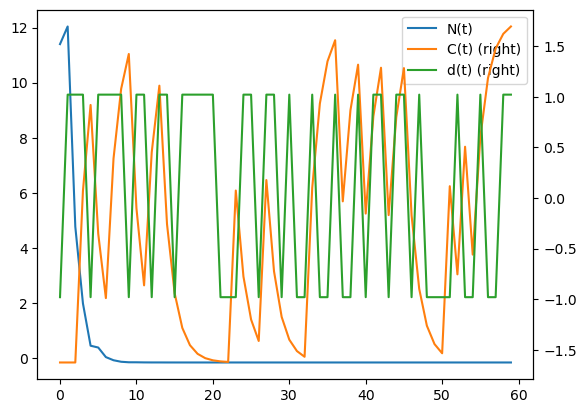

In [13]:
def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_dosage'][patient],
                       'd(t)': data['radio_dosage'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()

plot_treatments(test_data_factuals, 130)

In [14]:
test_data_counterfactuals.keys()

dict_keys(['cancer_volume', 'chemo_application', 'radio_application', 'sequence_lengths', 'patient_types'])

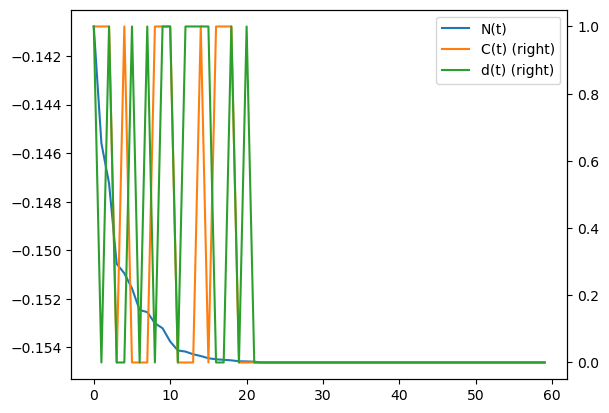

In [15]:
def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_application'][patient],
                       'd(t)': data['radio_application'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()

plot_treatments(test_data_counterfactuals, 34000)

In [16]:
training_data.keys()

dict_keys(['cancer_volume', 'chemo_dosage', 'radio_dosage', 'chemo_application', 'radio_application', 'chemo_probabilities', 'radio_probabilities', 'sequence_lengths', 'death_flags', 'recovery_flags', 'patient_types'])

In [17]:
# add a column that indicates the application of chemo and radio at time t-1

def add_previous_treatment(data: dict):
    data['chemo_application_prev'] = np.roll(data['chemo_application'], 1, axis=1)
    data['radio_application_prev'] = np.roll(data['radio_application'], 1, axis=1)
    data['chemo_application_prev'][:, 0] = 0
    data['radio_application_prev'][:, 0] = 0
    return data

training_data = add_previous_treatment(training_data)
validation_data = add_previous_treatment(validation_data)
test_data_factuals = add_previous_treatment(test_data_factuals)
test_data_counterfactuals = add_previous_treatment(test_data_counterfactuals)
test_data_seq = add_previous_treatment(test_data_seq)


def tile_patient_types(data: dict):
    data['patient_type_tile'] = np.tile(
        data['patient_types'][:, None], (1, data['cancer_volume'].shape[1]))
    return data


training_data = tile_patient_types(training_data)
validation_data = tile_patient_types(validation_data)
test_data_factuals = tile_patient_types(test_data_factuals)
test_data_counterfactuals = tile_patient_types(test_data_counterfactuals)
test_data_seq = tile_patient_types(test_data_seq)

def add_time_steps(data: dict): # this should be the same shape as the cancer_volume (patients, time_steps)
    data['time_step'] = np.tile(np.arange(data['cancer_volume'].shape[1]), (data['cancer_volume'].shape[0], 1))
    return data

#sequence lengths is reported once per patient, so we tile it to match the shape of the data
def add_sequence_lengths(data: dict):
    data['sequence_length_tile'] = np.tile(data['sequence_lengths'][:, None], (1, data['cancer_volume'].shape[1]))
    data['distance_from_end'] = data['sequence_length_tile'] - data['time_step']
    #distance_from_end_scaled is a value between 0 and 1 that indicates how far we are from the end of the sequence for each patient
    data['distance_from_end_scaled'] = data['distance_from_end'] / data['sequence_length_tile']
    return data


training_data = add_time_steps(training_data)
validation_data = add_time_steps(validation_data)
test_data_factuals = add_time_steps(test_data_factuals)
test_data_counterfactuals = add_time_steps(test_data_counterfactuals)
test_data_seq = add_time_steps(test_data_seq)

training_data = add_sequence_lengths(training_data)
validation_data = add_sequence_lengths(validation_data)
test_data_factuals = add_sequence_lengths(test_data_factuals)
test_data_counterfactuals = add_sequence_lengths(test_data_counterfactuals)
test_data_seq = add_sequence_lengths(test_data_seq)


# if distance from end is less than 0, we set all the other columns to nan
def mask_data(data: dict):
    for key in data.keys():
        if data[key].shape == data['distance_from_end'].shape:
            data[key] = np.where(data['distance_from_end'] < 0, np.nan, data[key])
    return data


training_data = mask_data(training_data)
validation_data = mask_data(validation_data)
test_data_factuals = mask_data(test_data_factuals)
test_data_counterfactuals = mask_data(test_data_counterfactuals)
test_data_seq = mask_data(test_data_seq)

training_data = add_sequence_lengths(training_data)
validation_data = add_sequence_lengths(validation_data)
test_data_factuals = add_sequence_lengths(test_data_factuals)
test_data_counterfactuals = add_sequence_lengths(test_data_counterfactuals)
test_data_seq = add_sequence_lengths(test_data_seq)

In [18]:
training_data

{'cancer_volume': array([[-0.14253892, -0.14230123, -0.14682599, ..., -0.15461667,
         -0.15461668, -0.15461669],
        [-0.15431954, -0.15430754, -0.15446043, ...,         nan,
                 nan,         nan],
        [-0.14318826, -0.14165783, -0.14187445, ..., -0.1546167 ,
         -0.15461669, -0.15461669],
        ...,
        [-0.15419914, -0.15415522, -0.15444021, ...,         nan,
                 nan,         nan],
        [ 8.07169424,  7.98565348,  2.76231333, ...,         nan,
                 nan,         nan],
        [ 0.3590803 ,  0.39136144,  0.0383445 , ..., -0.1546167 ,
         -0.1546167 , -0.1546167 ]]),
 'chemo_dosage': array([[-1.6241686 ,  0.07144106, -0.77636377, ...,  0.13733069,
          0.9521907 ,  1.35962071],
        [-1.6241686 , -1.6241686 , -1.6241686 , ...,         nan,
                 nan,         nan],
        [-1.6241686 ,  0.07144106, -0.77636377, ..., -0.60011785,
          0.58346643, -0.52035108],
        ...,
        [-1.6241686 ,

In [19]:
# training_data['time_step'].shape
# training_data['sequence_length_tile'].shape
training_data['chemo_application_prev'].shape

(10000, 60)

In [20]:
training_data_sequence_lengths = training_data['sequence_lengths']
validation_data_sequence_lengths = validation_data['sequence_lengths']
test_data_factuals_sequence_lengths = test_data_factuals['sequence_lengths']
test_data_counterfactuals_sequence_lengths = test_data_counterfactuals['sequence_lengths']
test_data_seq_sequence_lengths = test_data_seq['sequence_lengths']

In [21]:
#count of the unique values of the sequence lengths
np.unique(training_data_sequence_lengths, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., 55., 56., 57., 58., 59.]),
 array([  15,  136,  100,   56,   34,   29,   23,   14,    9,    6,    9,
           7,    6,    5,    8,   12,    7,   21,   10,   22,   33,   29,
          34,   46,   39,   52,   43,   53,   44,   59,   58,   62,   60,
          67,   70,   72,   84,   85,   85,   85,  105,   99,  104,  101,
         129,  108,   90,  118,  121,  110,  119,  103,  105,   90,  112,
         107,  102,  104, 6384]))

In [22]:
np.unique(test_data_counterfactuals_sequence_lengths, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., 55., 56., 57., 58., 59.]),
 array([4000, 3944, 3920, 3888, 3864, 3852, 3852, 3848, 3840, 3828, 3828,
        3824, 3820, 3820, 3812, 3808, 3800, 3800, 3796, 3780, 3780, 3772,
        3764, 3744, 3716, 3692, 3684, 3660, 3636, 3612, 3600, 3588, 3552,
        3532, 3492, 3456, 3420, 3372, 3352, 3320, 3272, 3240, 3200, 3164,
        3132, 3088, 3056, 3028, 2984, 2952, 2916, 2888, 2844, 2796, 2752,
        2716, 2680, 2624, 2568]))

In [23]:
needed_keys = [
    'chemo_application_prev', 'radio_application_prev', 'patient_type_tile', 'cancer_volume'
]
# 
training_data = {key: training_data[key] for key in needed_keys}
validation_data = {key: validation_data[key] for key in needed_keys}
test_data_factuals = {key: test_data_factuals[key] for key in needed_keys}
test_data_counterfactuals = {key: test_data_counterfactuals[key] for key in needed_keys}
test_data_seq = {key: test_data_seq[key] for key in needed_keys}

In [24]:
#convert tensors where the first dimension is the number of patients the second dimension is time and the third is the features
#the keys are the features
#within the features, the first dimension is the number of patients, the second is time

#convert the keys to a dimension in the tensor
def dictionary_to_tensor(data_dict):
    # Extract keys and values from the dictionary
    keys = list(data_dict.keys())
    values = [data_dict[key] for key in keys]
    
    # Check consistency in dimensions
    num_patients = values[0].shape[0]
    time_steps = values[0].shape[1]
    
    for table in values:
        assert table.shape[0] == num_patients, "Number of patients mismatch."
        assert table.shape[1] == time_steps, "Number of time steps mismatch."
    
    # Stack tables along the new feature dimension
    tensor = np.stack(values, axis=-1)
    tensor = torch.tensor(tensor, dtype=torch.float32)
    
    return tensor, keys
    
training_data_tensor, keys = dictionary_to_tensor(training_data)
validation_data_tensor, keys = dictionary_to_tensor(validation_data)
test_data_factuals_tensor, keys = dictionary_to_tensor(test_data_factuals)
test_data_counterfactuals_tensor, keys = dictionary_to_tensor(test_data_counterfactuals)
test_data_seq_tensor, keys = dictionary_to_tensor(test_data_seq)

In [25]:
training_data_tensor.shape
test_data_counterfactuals_tensor.shape
test_data_seq_tensor.shape

torch.Size([10000, 60, 4])

torch.Size([204568, 60, 4])

torch.Size([502044, 65, 4])

In [26]:
test_data_counterfactuals_sequence_lengths.shape
test_data_seq_sequence_lengths.shape

(204568,)

(502044,)

## Data embedding before feeding into the model

This will first one-hot encode all the categorical features and then embed them to n columns. The resulting columns will then be concatenated with the numerical features. The result will then be used to create the torch tensor for the model. The torch tensor will be shaped as (Cases, Time, Features).

The input data will be a dataframe like this:





In [ ]:
class DataEmbedder(nn.Module):
    def __init__(self, categorical_indices_sizes, numerical_indices, dataset):
        super(DataEmbedder, self).__init__()
        # dictionary with feature name, and a list of index and size
        self.categoricals = categorical_indices_sizes
        self.numerics = numerical_indices  # dictionary with feature name and index
        self.embeddings = nn.ModuleDict()
        self.mapping_dicts = {}

        # Initialize embeddings and mapping dictionaries
        for key in self.categoricals:
            unique_values = np.unique(dataset[:, :, self.categoricals[key][0]])
            self.mapping_dicts[key] = {
                name: idx for idx, name in enumerate(unique_values)}
            self.embeddings[key] = nn.Embedding(num_embeddings=len(
                unique_values), embedding_dim=self.categoricals[key][1])
            print(f"Feature: {key}, Categories: {len(unique_values)}, Embedding Size: {self.categoricals[key][1]}")

    def forward(self, dataset):
        # Apply embeddings to the categorical indices
        if len(self.categoricals) == 0:
            return dataset
        else:
            embedded_features = []
            for key in self.categoricals:
                # Map the categorical values to their corresponding indices
                indices = dataset[:, :, self.categoricals[key][0]].cpu().numpy()
                mapped_indices = np.vectorize(self.mapping_dicts[key].get)(indices)
                mapped_indices = torch.tensor(
                    mapped_indices, dtype=torch.long, device=dataset.device)
                # print(f"Feature: {key}, Mapped Indices: {mapped_indices}")
                embedded_features.append(self.embeddings[key](mapped_indices))

            embedded_features = torch.cat(embedded_features, dim=-1)

            numeric_features = dataset[:, :, list(self.numerics.values())].float()

            # Concatenate the embedded features with the numerical data
            result = torch.cat([embedded_features, numeric_features], dim=-1)

            feature_count_embedded = len(
                self.numerics) + sum([self.categoricals[key][1] for key in self.categoricals])

            result = result.reshape(dataset.shape[0], -1, feature_count_embedded)

            return result

# Transformer

## Moded Transformer

In [ ]:
class moded_TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(moded_TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)#(self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)#, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4)#, 5) # BxHxTxFxDxD


        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)


        #softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b*h, t*f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfd->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [ ]:
class moded_TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoderCell, self).__init__()

        self.time_series_attention = moded_TimesSeriesAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention2 = self.time_series_attention(x, x, x, mask)
        attention = x + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(
            self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention


In [ ]:
class moded_TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float = 0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(moded_TransformerEncoderCell(
            embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y


## RSA

In [ ]:
class TimesSeriesAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_out,
        nh=8,
        dk=0,
        dv=0,
        dd=0,
        kernel_size=(3, 7),
        stride=(1,1,1),
        kernel_type='VplusR',  # ['V', 'R', 'VplusR']
        feat_type='VplusR',  # ['V', 'R', 'VplusR']
    ):
        super(TimesSeriesAttention, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.nh = nh
        self.dv = dv = d_out // nh if dv == 0 else dv
        self.dk = dk = dv if dk == 0 else dk
        self.dd = dd = dk if dd == 0 else dd

        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_type = kernel_type
        self.feat_type = feat_type

        assert self.kernel_type in [
            'V', 'R', 'VplusR'], "Not implemented involution type: {}".format(self.kernel_type)
        assert self.feat_type in [
            'V', 'R', 'VplusR'], "Not implemented feature type: {}".format(self.feat_type)

        # print("d_in: {}, d_out: {}, nh: {}, dk: {}, dv: {}, dd:{}, kernel_size: {}, kernel_type: {}, feat_type: {}"
        #       .format(d_in, d_out, nh, dk, dv, self.dd, kernel_size, kernel_type, feat_type))

        self.ksize = ksize = kernel_size[0] * kernel_size[1]
        self.pad = pad = tuple(k//2 for k in kernel_size)

        # hidden dimension
        d_hid = nh * dk + dv if self.kernel_type == 'V' else nh * dk + dk + dv

        # Linear projection
        #self.projection = nn.Conv2d(d_in, d_hid, 1, bias=False)
        self.projection_linear = nn.Sequential(
            nn.Linear(d_in, d_hid, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(d_hid, d_hid, bias=False)
        )

        # Intervolution Kernel
        if self.kernel_type == 'V':
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'R':
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'VplusR':
            self.P1 = nn.Parameter(torch.randn(dk, dd).unsqueeze(
                0)*np.sqrt(1/(ksize*dd)), requires_grad=True)
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        else:
            raise NotImplementedError

        # Feature embedding layer
        if self.feat_type == 'V':
            pass
        elif self.feat_type == 'R':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
        elif self.feat_type == 'VplusR':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
            self.I = nn.Parameter(torch.eye(dk).unsqueeze(0), requires_grad=True)
        else:
            raise NotImplementedError

        # Downsampling layer
        if max(self.stride) > 1:
            self.avgpool = nn.AvgPool2d(kernel_size=(
                1, 3), stride=(1, 2), padding=(0, 1))

    def L2norm(self, x, d=1):
        eps = 1e-6
        norm = x ** 2
        norm = norm.sum(dim=d, keepdim=True) + eps
        norm = norm ** (0.5)
        return (x / norm)

    def forward(self, x):
                
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        N, C, T, H= x.shape

        x = x.permute(0, 2, 3, 1)
        
        '''Linear projection'''
        #x_proj = self.projection(x)
        x_proj = self.projection_linear(x)
        x_proj = x_proj.permute(0, 3, 1, 2)
        #print(x_proj.shape)

        if self.kernel_type != 'V':
            q, k, v = torch.split(
                x_proj, [self.nh * self.dk, self.dk, self.dv], dim=1)
        else:
            q, v = torch.split(x_proj, [self.nh * self.dk, self.dv], dim=1)

        '''Normalization'''
        q = rearrange(q, 'b (nh k) t h -> b nh k t h', k=self.dk)
        q = self.L2norm(q, d=2)
        q = rearrange(q, 'b nh k t h -> (b t h) nh k')

        v = self.L2norm(v, d=1)

        if self.kernel_type != 'V':
            k = self.L2norm(k, d=1)

        '''
        q = (b t h) nh k
        k = b k t h
        v = b v t h
        '''

        #Intervolution generation
        # Basic kernel
        if self.kernel_type == 'V':
            kernel = q
        # Relational kernel
        else:
            K_H1 = self.H1(k)
            K_H1 = rearrange(K_H1, 'b (k d) t h-> (b t h) k d', k=self.dk)

            if self.kernel_type == 'VplusR':
                K_H1 = K_H1 + self.P1

            kernel = torch.einsum(
                'abc,abd->acd', q.transpose(1, 2), K_H1)  # (bth, nh, d)

        #feature generation
        # Appearance feature
        v = rearrange(v, 'b (v 1) t h-> (b v) 1 t h')

        V = self.H2(v)  # (bv, d, t, h)
        feature = rearrange(V, '(b v) d t h -> (b t h) v d', v=self.dv)

        # Relational feature
        if self.feat_type in ['R', 'VplusR']:
            V_G = self.G(v)  # (bv, v2, t, h)
            V_G = rearrange(V_G, '(b v) v2 t h -> (b t h) v v2', v=self.dv)

            if self.feat_type == 'VplusR':
                V_G = V_G + self.I

            feature = torch.einsum('abc,abd->acd', V_G, feature)  # (bth, v2, d)

        #kernel * feat
        out = torch.einsum('abc,adc->adb', kernel, feature)  # (bth, nh, v2)

        out = rearrange(out, '(b t h) nh v -> b (nh v) t h', t=T, h=H)

        if max(self.stride) > 1:
            out = self.avgpool(out)

        out = out.permute(0, 2, 3, 1)

        return out


In [ ]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, embed_dim, nh = num_heads, kernel_size=kernel_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)


    def forward(self, data: torch.Tensor,embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        #attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [ ]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, kernel_size, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## CSDI transformer

In [ ]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, activation="gelu", dropout=dropout
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings

In [ ]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(2).repeat((1,1,f,1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe
        
        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(1).repeat((1,l,1,1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block

In [ ]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num_heads=8, num_cells=1, kernel_size=(3, 7), embed_dim=128, ff_dim=512, dropout=0.1, method = "rsa"):
        super().__init__()

        self.method = method

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim*4, embed_dim*4),
            nn.SiLU(),
            nn.Linear(embed_dim*4, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        


        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        if method == "rsa":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            
        elif method == "csdi":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "csdi_moded_transformer":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "rsa_csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        
        elif method == "rsa_moded_transformer":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "moded_transformer_alone":
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        else:
            raise NotImplementedError


        
        
    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y        


    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):

        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape
        
        y = torch.stack((noised_data, diffusion_emb, time_emb, feature_emb), dim = -1)
        y = y.reshape(b, t, f, -1)
        y = self.embedding_add(y)
        y_resid = y

        if self.method == "rsa":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
        
        elif self.method == "csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_moded_transformer":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)
        
        elif self.method == "moded_transformer_alone":
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)

        
        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t*f)
        y = self.mid_projection(y)
        #y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        #y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        #y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [ ]:
class ModelLoop(nn.Module):
    def __init__(self, embed_dim=128, diffusion_steps = 1000, num_heads=8, kernel_size=(3, 7),num_cells=1, num_residual_layers = 4, ff_dim=512, dropout=0.1, method = "rsa", device = "cpu"):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)
        
        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)
        
        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
                ResidualBlock(
                    num_heads=num_heads,
                    num_cells=num_cells,
                    kernel_size=kernel_size,
                    embed_dim=embed_dim,
                    ff_dim=ff_dim,
                    dropout=dropout,
                    method = method
                ) for _ in range(num_residual_layers)
        )
    
        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )


    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape
        
        noised_data_reshaped = noised_data.permute(0, 3, 1, 2).reshape(b, 1, t*f)
        noised_data_embedded = self.data_embedding_linear(noised_data_reshaped).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data_embedded, device = self.device)
        time_embedding = self.time_embedding(noised_data_embedded, device = self.device)
        feature_embedding = self.feature_embedding(noised_data_embedded, device = self.device)

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_embedding, time_embedding, feature_embedding)
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim = -1)
            #x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t*f)
            x = self.x_embedding(x).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim = -1), dim=-1)/ math.sqrt(len(self.residual_layers))
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        #x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
        x = self.output_final(x).permute(0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules

In [ ]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return torch.linspace(
            beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps
        ) ** 2

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer

In [ ]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim, excluded_features = None,
                #vocab_size,
                #pad_idx= None,
                strategy = "random",
                num_residual_layers = 4,
                features_to_impute = None,
                features_to_impute_completely = None,
                features_to_impute_after_time = None,
                last_n_time = 1,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "quadratic",
                num_heads = 8,
                kernel_size=(3, 7),
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                method = "rsa",
                device = "cpu"):
        
        super().__init__()

    
        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time
        self.exclude_features = excluded_features   
        self.features_to_impute_completely = features_to_impute_completely
        self.features_to_impute_after_time = features_to_impute_after_time

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        
        self.model_loop = ModelLoop(embed_dim = self.emb_dim,
                                    diffusion_steps = diffusion_steps,
                                    num_heads = num_heads,
                                    kernel_size = kernel_size,
                                    ff_dim = ff_dim,
                                    num_cells = num_cells,
                                    dropout = dropout,
                                    num_residual_layers = num_residual_layers,
                                    method = method,
                                    device = self.device)
        
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def get_mask(self, data, strategy = "random"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            #death is the last 7 columns of the data
            mask[:,:, -1] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()

        if strategy == "selected_features_and_selected_features_after_time":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute_completely] = 1
            mask[:, -self.last_n_time:, self.features_to_impute_after_time] = 1

        if self.exclude_features is not None:
            mask[:, :, self.exclude_features] = 0

        return mask
    
    def loss_func(self, predicted_noise, noise, noise_mask):
        # noise = torch.nan_to_num(noise, nan=0.0)
        # predicted_noise = torch.nan_to_num(predicted_noise, nan=0.0)
        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data):
         
        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha)**0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)
    
    def eval_with_grad(self, data, scale=1):

        #with torch.no_grad():
        imputation_mask = self.get_mask(data, self.strategy).to(self.device)
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask * scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        for t in range(self.diffusion_steps - 1, -1, -1):

            x = x.unsqueeze(3).float()
            predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
            predicted_noise = predicted_noise * imputation_mask
            
            coeff1 = 1 / self.alpha_hat[t] ** 0.5
            coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
            
            x = x.squeeze(3)
            x = coeff1 * (x - coeff2 * predicted_noise)
            
            if t > 0:
                noise = torch.randn_like(x)
                sigma = (
                    (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                ) ** 0.5
                x += sigma * noise
            
            x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            
            imputed_samples = x

        return(imputed_samples, data, imputation_mask)

    
    def eval(self, data, imputation_mask, mean, std, scale=1 , verbose = True, show_max_diff = False, show_rmse = False):
        
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask *scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
                predicted_noise = predicted_noise * imputation_mask
                
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            

            imputed_samples = x.detach()
        
        if show_max_diff == True:
            #show the data at torch.max(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))
            print("max difference = ", torch.max(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item())
            print("data at max difference = ", data[imputation_mask !=0][torch.argmax(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))].item())
            print("imputed at max difference = ", imputed_samples[imputation_mask !=0][torch.argmax(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))].item())
        
        mae = torch.mean(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item()
        if verbose == True:
            print("mae = ", mae)
        
        if show_rmse == True:
            #descale the data
            imputed_samples_copy = imputed_samples.detach().clone()
            imputed_samples_copy = imputed_samples_copy * std + mean
            data_copy = data.detach().clone()
            data_copy = data_copy * std + mean
            rmse = torch.sqrt(torch.mean((data_copy[imputation_mask !=0] - imputed_samples_copy[imputation_mask !=0])**2)).item()
            rmse = rmse / 1150 * 100
            print("rmse = ", rmse)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return(imputed_samples, data, imputation_mask, mae)

# Training

In [ ]:
# %matplotlib inline
# from IPython.display import display, clear_output
# import matplotlib.pyplot as plt
# import time
# import statistics
# from itertools import chain
# import numpy as np
# from collections import deque

# def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder,
#           windowed_mode=False, window_mode="uniform", window_start_mode="random", min_window=50, max_window=100, neg_bin_p=0.95, train_on_all_every=4,
#           annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
#           device="cuda", verbose=False, plot_every=10,
#           validation_frequency=1, validation_prp=10, moving_avg_window=10):
    
#     batch_embedder = batch_embedder.to(device)
#     model = model.to(device)
    
#     optimizer = torch.optim.Adam(
#         chain(batch_embedder.parameters(), model.parameters()),
#         lr=lr
#     )

#     model.train()
#     batch_embedder.train()
#     loss_list = []
#     initial_value = 1.0  # Initial value for equal probability
#     window_losses = torch.ones(max_window - min_window + 1, device=device) * initial_value  # Track losses for each window length
#     window_counts = torch.zeros(max_window - min_window + 1, device=device)  # Track counts for each window length
#     loss_deques = [deque(maxlen=moving_avg_window) for _ in range(max_window - min_window + 1)]  # Deques for moving average
#     if windowed_mode and window_mode == "biased_loss":
#         fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
#     else:
#         fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
#     epoch_loss_list = []
#     val_loss = 0

#     for epoch in range(epochs):
#         # Annealing for the learning rate
#         if annealing_mode and epoch > annealing_window:
#             if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
#                 for g in optimizer.param_groups:
#                     if g['lr'] * annealing_ratio < annealing_minimum:
#                         g['lr'] = annealing_minimum
#                     else:
#                         g['lr'] *= annealing_ratio

#         start = time.time()
#         for i, batch in enumerate(data_loader):
            
#             batch = batch.to(device)
#             batch = batch_embedder(batch)

#             batch_length = batch.shape[1]

#             # Windowed mode logic
#             if windowed_mode:
#                 if batch_length < min_window:
#                     continue
#                 if window_start_mode == "random":
#                     cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
#                 elif window_start_mode == "fixed":
#                     cut_start = 0
#                 if window_mode == "uniform":
#                     while True:
#                         window_length = torch.randint(min_window, batch_length + 1, (1,)).item()
#                         cut_end = cut_start + window_length
#                         if min_window <= (cut_end - cut_start) <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]

#                 elif window_mode == "negative_binomial":
#                     total_count = 1
#                     probs = neg_bin_p
#                     distribution = torch.distributions.NegativeBinomial(total_count=total_count, probs=probs)
#                     while True:
#                         window_length = distribution.sample().item() + min_window
#                         cut_end = cut_start + window_length
#                         if min_window <= window_length <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]

#                 elif window_mode == "biased_loss":
#                     if torch.min(window_counts) < 2:
#                         # Use uniform distribution until each length has been used at least twice
#                         window_probs = torch.ones_like(window_losses) / len(window_losses)
#                     elif torch.sum(window_counts) % train_on_all_every == 0:
#                         window_probs = torch.ones_like(window_losses) / len(window_losses)
#                     else:
#                         # Update probabilities based on moving average of losses
#                         avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device)
#                         window_probs = avg_losses / avg_losses.sum()
#                     while True:
#                         window_length = torch.multinomial(window_probs, 1).item() + min_window
#                         #check if the window length does work with the batch length
#                         if window_length > batch_length:
#                             continue
#                         cut_end = cut_start + window_length
#                         if min_window <= window_length <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]
#                     window_counts[window_length - min_window] += 1  # Update window counts

#             optimizer.zero_grad()
#             predicted_noise, noise, noise_mask = model(batch)
#             loss = loss_func(predicted_noise, noise, noise_mask)
#             loss.backward()
#             # # Gradient clipping
#             max_grad_norm = 1.0
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             torch.nn.utils.clip_grad_norm_(batch_embedder.parameters(), max_grad_norm)
#             optimizer.step()
#             loss_list.append(loss.item())

#             epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
#             epoch_loss_list.append(epoch_loss)
            
#             # Update window losses and moving average deque
#             if windowed_mode and window_mode == "biased_loss":
#                 window_idx = window_length - min_window
#                 window_losses[window_idx] += loss.item()
#                 loss_deques[window_idx].append(loss.item())

#             # Dynamic plot update
#             if i % plot_every == 0:
#                 ax1.clear()
#                 ax1.set_ylim(0, 1)
#                 ax1.plot(loss_list)
#                 if len(loss_list) > 100:
#                     ax1.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
#                     ax1.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
#                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
#                 if len(epoch_loss_list) > 0:
#                     ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
#                 # ax1.text(0.1, 0.8, f"Learning rate: {optimizer.param_groups[0]['lr']:.4e}")
#                 ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}")
#                 ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s")
#                 ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min")
#                 if windowed_mode and window_mode == "biased_loss":
#                     ax2.clear()
#                     ax2.bar(range(min_window, max_window + 1), window_counts.cpu().numpy())
#                     ax2.set_ylabel("Counts")
#                     ax2.set_title("Counts of Each Window Length Used")

#                     moving_avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device).cpu().numpy()
#                     ax3.clear()
#                     ax3.bar(range(min_window, max_window + 1), moving_avg_losses)
#                     ax3.set_xlabel("Window Length")
#                     ax3.set_ylabel("Moving Average Loss")
#                     ax3.set_title("Moving Average Loss for Each Window Length")

#                 display(fig)
#                 clear_output(wait=True)

#         end = time.time()

#         # Validation
#         if epoch % validation_frequency == 0:
#             loss_list_validation = []
#             for i, batch in enumerate(data_loader_validation):
#                 batch = batch.to(device)
#                 batch = batch_embedder(batch)
#                 if i % validation_prp == 0:
#                     predicted_noise, noise, noise_mask = model(batch)
#                     loss = loss_func(predicted_noise, noise, noise_mask)
#                     loss_list_validation.append(loss.item())

#             val_loss = np.mean(loss_list_validation)

#         if verbose:
#             print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
#             print(f"Validation Loss: {val_loss}")


#     return model, loss_list


In [ ]:
import torch
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics
from itertools import chain
import numpy as np
from collections import deque

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder = None, gradient_clip = 1.0,
          windowed_mode=False, window_mode="uniform", window_start_mode="random", min_window=50, max_window=100, neg_bin_p=0.95, train_on_all_every=4,
          annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
          device="cuda", num_gpus=1, verbose=False, plot_every=10,
          validation_frequency=1, validation_prp=10, moving_avg_window=10):

    # Check for GPU availability
    available_gpus = torch.cuda.device_count()
    if available_gpus < num_gpus:
        print(f"Requested {num_gpus} GPUs, but only {available_gpus} are available.")
        num_gpus = available_gpus
    else:
        print(f"Using {num_gpus} GPUs for training.")
    
    if num_gpus > 1:
        model = torch.nn.DataParallel(model, device_ids=list(range(num_gpus)))
        if batch_embedder is not None:
            batch_embedder = torch.nn.DataParallel(batch_embedder, device_ids=list(range(num_gpus)))

    if batch_embedder is not None:
        batch_embedder = batch_embedder.to(device)
    model = model.to(device)
    
    if batch_embedder is not None:
        optimizer = torch.optim.Adam(
            chain(batch_embedder.parameters(), model.parameters()),
            lr=lr
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr
        )

    model.train()

    if batch_embedder is not None:
        batch_embedder.train()
    
    loss_list = []
    initial_value = 1.0  # Initial value for equal probability
    window_losses = torch.ones(max_window - min_window + 1, device=device) * initial_value  # Track losses for each window length
    window_counts = torch.zeros(max_window - min_window + 1, device=device)  # Track counts for each window length
    loss_deques = [deque(maxlen=moving_avg_window) for _ in range(max_window - min_window + 1)]  # Deques for moving average
    if windowed_mode and window_mode == "biased_loss":
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    epoch_loss_list = []
    val_loss = 0

    total_time_start = time.time()

    for epoch in range(epochs):
        # Annealing for the learning rate
        if annealing_mode and epoch > annealing_window:
            if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
                for g in optimizer.param_groups:
                    if g['lr'] * annealing_ratio < annealing_minimum:
                        g['lr'] = annealing_minimum
                    else:
                        g['lr'] *= annealing_ratio

        start = time.time()
        for i, batch in enumerate(data_loader):
            
            batch = batch.to(device)

            if batch_embedder is not None:
                batch = batch_embedder(batch)

            batch_length = batch.shape[1]

            # Windowed mode logic
            if windowed_mode:
                if batch_length < min_window:
                    continue
                if window_start_mode == "random":
                    cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
                elif window_start_mode == "fixed":
                    cut_start = 0
                if window_mode == "uniform":
                    while True:
                        window_length = torch.randint(min_window, batch_length + 1, (1,)).item()
                        cut_end = cut_start + window_length
                        if min_window <= (cut_end - cut_start) <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "negative_binomial":
                    total_count = 1
                    probs = neg_bin_p
                    distribution = torch.distributions.NegativeBinomial(total_count=total_count, probs=probs)
                    while True:
                        window_length = distribution.sample().item() + min_window
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "biased_loss":
                    if torch.min(window_counts) < 2:
                        # Use uniform distribution until each length has been used at least twice
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    elif torch.sum(window_counts) % train_on_all_every == 0:
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    else:
                        # Update probabilities based on moving average of losses
                        avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device)
                        window_probs = avg_losses / avg_losses.sum()
                    while True:
                        window_length = torch.multinomial(window_probs, 1).item() + min_window
                        #check if the window length does work with the batch length
                        if window_length > batch_length:
                            continue
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]
                    window_counts[window_length - min_window] += 1  # Update window counts

            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch)
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            # # Gradient clipping
            if gradient_clip is not None:
                max_grad_norm = gradient_clip
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                if batch_embedder is not None:
                    torch.nn.utils.clip_grad_norm_(batch_embedder.parameters(), max_grad_norm)
            optimizer.step()
            loss_list.append(loss.item())

            epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
            epoch_loss_list.append(epoch_loss)
            
            # Update window losses and moving average deque
            if windowed_mode and window_mode == "biased_loss":
                window_idx = window_length - min_window
                window_losses[window_idx] += loss.item()
                loss_deques[window_idx].append(loss.item())

            # Dynamic plot update
            if i % plot_every == 0:
                ax1.clear()
                ax1.set_ylim(0, 1)
                ax1.plot(loss_list)
                if len(loss_list) > 100:
                    ax1.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    ax1.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                            str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                if len(epoch_loss_list) > 0:
                    ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
                # ax1.text(0.1, 0.8, f"Learning rate: {optimizer.param_groups[0]['lr']:.4e}")
                ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}")
                ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s")
                ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min")
                if windowed_mode and window_mode == "biased_loss":
                    ax2.clear()
                    ax2.bar(range(min_window, max_window + 1), window_counts.cpu().numpy())
                    ax2.set_ylabel("Counts")
                    ax2.set_title("Counts of Each Window Length Used")

                    moving_avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device).cpu().numpy()
                    ax3.clear()
                    ax3.bar(range(min_window, max_window + 1), moving_avg_losses)
                    ax3.set_xlabel("Window Length")
                    ax3.set_ylabel("Moving Average Loss")
                    ax3.set_title("Moving Average Loss for Each Window Length")

                display(fig)
                clear_output(wait=True)

        end = time.time()

        # Validation
        if epoch % validation_frequency == 0:
            loss_list_validation = []
            for i, batch in enumerate(data_loader_validation):
                batch = batch.to(device)
                if batch_embedder is not None:
                    batch = batch_embedder(batch)
                if i % validation_prp == 0:
                    predicted_noise, noise, noise_mask = model(batch)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)

        total_time_end = time.time()
        total_time = total_time_end - total_time_start
        
        if verbose:
            print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
            print(f"Validation Loss: {val_loss}")
    
    print(f"Took {total_time} seconds for {epoch} epochs.")
            


    return model, loss_list

In [ ]:
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from collections import defaultdict
import torch
from torch.utils.data import Dataset


class CustomTimeSeriesDataset(Dataset):
    def __init__(self, data_tensor, sequence_lengths, min_seq_length=None, max_seq_length=None):
        # Store the initial sequences and lengths
        self.data_tensor = data_tensor
        self.sequence_lengths = sequence_lengths
        self.min_seq_length = min_seq_length
        self.max_seq_length = max_seq_length

        # Filter sequences based on min and max sequence length
        if self.min_seq_length is not None:
            valid_indices = [i for i, length in enumerate(
                self.sequence_lengths) if length >= self.min_seq_length]
        else:
            valid_indices = list(range(len(self.sequence_lengths)))

        if self.max_seq_length is not None:
            valid_indices = [
                i for i in valid_indices if self.sequence_lengths[i] <= self.max_seq_length]

        self.data_tensor = self.data_tensor[valid_indices]
        self.sequence_lengths = [self.sequence_lengths[i]
                                 for i in valid_indices]

    def __len__(self):
        return len(self.sequence_lengths)

    def __getitem__(self, idx):
        seq_length = int(self.sequence_lengths[idx])
        return self.data_tensor[idx, :seq_length, :], seq_length


# class CustomTimeSeriesDataset(Dataset):
#     def __init__(self, data_tensor, sequence_lengths, min_seq_length=None, max_seq_length=None):
#         self.data_tensor = data_tensor
#         self.sequence_lengths = sequence_lengths

#     def __len__(self):
#         return len(self.sequence_lengths)

#     def __getitem__(self, idx):
#         seq_length = int(self.sequence_lengths[idx])
#         return self.data_tensor[idx, :seq_length, :], seq_length


class LengthBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.sequence_lengths = dataset.sequence_lengths
        self.batch_size = batch_size
        self.batches = self._create_batches()

    def _create_batches(self):
        length_to_indices = defaultdict(list)
        for idx, length in enumerate(self.sequence_lengths):
            length_to_indices[length].append(idx)

        batches = []
        for length, indices in length_to_indices.items():
            # Split indices into batches of the specified batch size
            for i in range(0, len(indices), self.batch_size):
                batches.append(indices[i:i + self.batch_size])
        return batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


def collate_fn(batch):
    data, lengths = zip(*batch)
    data = torch.stack(data)
    return data


def create_dataloader(data_tensor, sequence_lengths, batch_size, min_seq_length=None, max_seq_length=None):
    dataset = CustomTimeSeriesDataset(
        data_tensor, sequence_lengths, min_seq_length, max_seq_length)
    sampler = LengthBatchSampler(dataset, batch_size)
    dataloader = DataLoader(
        dataset, batch_sampler=sampler, collate_fn=collate_fn)
    return dataloader



class BalancedLengthBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, balance_factor=1.0):
        self.sequence_lengths = dataset.sequence_lengths
        self.batch_size = batch_size
        self.balance_factor = balance_factor
        self.batches = self._create_balanced_batches()

    def _create_balanced_batches(self):
        # Group indices by sequence length
        length_to_indices = defaultdict(list)
        for idx, length in enumerate(self.sequence_lengths):
            length_to_indices[length].append(idx)

        # Calculate the maximum count of indices for balancing
        max_count = max(len(indices) for indices in length_to_indices.values())

        # Balance the distribution of sequence lengths by oversampling shorter sequences
        balanced_batches = []
        for length, indices in length_to_indices.items():
            count = len(indices)
            if count < max_count:
                repeat_factor = int(self.balance_factor * (max_count / count))
                # Correctly oversample the list elements
                oversampled_indices = indices * repeat_factor
                # oversampled_indices = oversampled_indices[:max_count]
            else:
                oversampled_indices = indices

            # Shuffle the indices of this particular length
            random.shuffle(oversampled_indices)

            # Create batches for this length
            for i in range(0, len(oversampled_indices), self.batch_size):
                batch = oversampled_indices[i:i + self.batch_size]
                if len(batch) == self.batch_size:
                    balanced_batches.append(batch)

        # Shuffle the list of balanced batches to ensure random order
        random.shuffle(balanced_batches)

        return balanced_batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


def create_balanced_dataloader(data_tensor, sequence_lengths, batch_size, balance_factor=1.0, min_seq_length=None, max_seq_length=None):
    dataset = CustomTimeSeriesDataset(
        data_tensor, sequence_lengths, min_seq_length, max_seq_length)
    sampler = BalancedLengthBatchSampler(
        dataset, batch_size, balance_factor)
    dataloader = DataLoader(
        dataset, batch_sampler=sampler, collate_fn=collate_fn)
    return dataloader

In [ ]:
train_loader = create_balanced_dataloader(
    training_data_tensor, training_data_sequence_lengths, batch_size=100, balance_factor=1.0, min_seq_length=2, max_seq_length=None)

val_loader = create_balanced_dataloader(
    validation_data_tensor, validation_data_sequence_lengths, batch_size=100, balance_factor=1.0, min_seq_length=2, max_seq_length=None)

#check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))

3651
321


In [ ]:
training_data_tensor.shape

torch.Size([10000, 60, 4])

In [ ]:
categorical_indices_sizes = {
    # 'time_step' : [0, 1],
    # 'chemo_application_prev': [0, 1],
    # 'radio_application_prev': [1, 1],
    # 'patient_type_tile': [2, 1]
}

# numerical_indices = {
#     'cancer_volume': 3
# }

numerical_indices = {
    'chemo_application_prev': 0,
    'radio_application_prev': 1,
    'patient_type_tile': 2,
    'cancer_volume': 3
}


# training_data_tensor_embedded = data_embedder(training_data_tensor)
# validation_data_tensor_embedded = data_embedder(validation_data_tensor)
# test_data_factuals_tensor_embedded = data_embedder(test_data_factuals_tensor)
# test_data_counterfactuals_tensor_embedded = data_embedder(test_data_counterfactuals_tensor)
# test_data_seq_tensor_embedded = data_embedder(test_data_seq_tensor)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# diffusion_imputer = diffusion_imputation(emb_dim = 128,
#                                         # strategy='forecasting_last_n_time',
#                                         strategy='random',
#                                         missing_prp= 0.2,
#                                         # strategy='selected_features',
#                                         # strategy='selected_features_last_n_time',
#                                         # last_n_time=1,
#                                         # features_to_impute =[3],
#                                         # excluded_features = [i for i in range(6)], #[2],#[0,1,2,3,5], #for the embedded stock names which we don't need to predict
#                                         # strategy='selected_features_and_selected_features_after_time',
#                                         # features_to_impute_completely=[2],
#                                         # features_to_impute_after_time=[3],
#                                         num_residual_layers= 8,
#                                         diffusion_steps=50,
#                                         diffusion_beta_schedule="quadratic",
#                                         num_heads=16,
#                                         kernel_size=(1, 1),
#                                         ff_dim=2048,
#                                         num_cells=1,
#                                         dropout=0,
#                                          # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi
#                                         method="rsa_moded_transformer",
#                                         device="cuda")

# # data_embedder = DataEmbedder(categorical_indices_sizes, numerical_indices, training_data_tensor)

In [ ]:
# train(
#     diffusion_imputer, 
#     train_loader, 
#     val_loader,
#     num_gpus=4,
#     batch_embedder = None,#data_embedder,
#     gradient_clip=None,
#     windowed_mode = True,
#     window_mode = "biased_loss",
#     window_start_mode = "fixed",
#     train_on_all_every = 100,
#     min_window = 2,
#     max_window = 59,
#     device = "cuda",
#     epochs = 1,
#     lr = 1e-3,
#     annealing_mode = True,
#     annealing_window = 2,
#     annealing_multiplier = 1.0,
#     annealing_ratio=0.1,
#     annealing_minimum=1e-6,
#     loss_func = diffusion_imputer.loss_func,
#     validation_frequency = 2,
#     validation_prp = 1,
#     verbose = False,
#     plot_every = 20
#     )

In [ ]:
# train_hybrid(
#     diffusion_imputer, 
#     hybrid_model,
#     train_loader, 
#     val_loader,
#     batch_embedder = embedder,
#     epochs = 20,
#     lr = 0.001, 
#     annealing_window = 5,
#     annealing_multiplier = 1,
#     loss_func = diffusion_imputer.loss_func,
#     hybrid_loss_func = hybrid_model.loss_func,
#     hybrid_start_epoch = 0,
#     hybrid_every_n_epoch = 5,
#     validation_frequency=2, 
#     validation_prp=1)

In [ ]:

# # save the entire model for further training
# torch.save(diffusion_imputer, "diffusion_imputer_cancer_jul24.pt")
# torch.save(data_embedder, "data_embedder_cancer_jul24.pt")

# Evaluation

In [ ]:
import torch


def calculate_quantiles(imputed_samples_tensor, qlist):
    quantiles_imp = []
    for q in qlist:
        quantiles = torch.quantile(
            imputed_samples_tensor, q, dim=0, interpolation="midpoint")
        quantiles_imp.append(quantiles)
    return torch.stack(quantiles_imp, dim=0)

# Calculate RMSE with denormalization


def calculate_rmse(final_samples, training_mean, training_std, qlist=[0.05, 0.25, 0.50, 0.75, 0.95]):
    all_data = []
    all_imputed = []
    imputed_samples_list = []
    actual_data_list = []

    # Extract one instance of the actual data and imputation mask
    data_instance, imputation_mask_instance = None, None
    sample_number = len(final_samples)

    for sample in final_samples:
        for imputed_samples, data, imputation_mask, _ in sample:
            # Store imputed samples for quantile calculation
            imputed_samples_list.append(
                imputed_samples[imputation_mask != 0].cpu())
            actual_data_list.append(data[imputation_mask != 0].cpu())
            # Flatten the tensors and filter non-zero mask areas
            all_data.append(data[imputation_mask != 0].cpu())
            all_imputed.append(imputed_samples[imputation_mask != 0].cpu())

    # Concatenate all filtered elements
    all_data = torch.cat(all_data)
    all_imputed = torch.cat(all_imputed)

    # Concatenate all imputed samples and reshape to original dimensions
    imputed_samples_tensor = torch.cat(imputed_samples_list).reshape(
        sample_number, -1)
    
    # Concatenate all actual data and reshape to original dimensions
    actual_data_tensor = torch.cat(actual_data_list).reshape(sample_number, -1)
    actual_data_tensor = actual_data_tensor[0]
    
    # Denormalize the data
    all_data = all_data * training_std + training_mean
    all_imputed = all_imputed * training_std + training_mean

    # Calculate RMSE for all imputed values
    rmse = torch.sqrt(torch.mean((all_data - all_imputed) ** 2)).item()
    rmse = rmse / 1150 * 100  # Adjust the RMSE as per your requirement

    # Calculate quantiles
    quantiles_imp = calculate_quantiles(imputed_samples_tensor, qlist)
    medians = quantiles_imp[qlist.index(0.50)]  # Median is the 50th percentile

    # Denormalize the medians
    medians = medians * training_std + training_mean

    # Use the median for the new RMSE calculation
    actual_data_tensor = actual_data_tensor * training_std + training_mean

    # Calculate RMSE with medians
    rmse_median = torch.sqrt(torch.mean(
        (actual_data_tensor - medians) ** 2)).item()
    # Adjust the RMSE as per your requirement
    rmse_median = rmse_median / 1150 * 100

    return rmse, rmse_median

In [ ]:
# def run_multiple_evaluations(
#         dataloader, imputer, training_mean, training_std, sample_number, old_sample=[], 
#         min_sequence_len=2, max_sequence_len=None, scale=1,
#         verbose=True, show_max_diff=False, show_rmse=False):
#     final_samples = old_sample
#     max_seq_len = 0
#     total_batches = len(dataloader) * sample_number
#     completed_batches = 0
#     sample_time = []
#     average_sample_time = 0

#     for i in range(sample_number):
#         sample_start = time.time()
#         #print a line to separate the samples
#         print("-------------------------------------------------")
#         print(f"Running sample {i + 1}/{sample_number}")
#         all_samples = []

#         for batch_idx, data_batch in enumerate(dataloader):
#             # Get the data from the batch (collate_fn returns a tuple)
#             data_batch = data_batch.to(imputer.device)
#             seq_length = data_batch.shape[1]
#             if seq_length < min_sequence_len:
#                 # print(f"Skipping batch {batch_idx + 1} as sequence length is less than {min_sequence_len}")
#                 completed_batches += 1
#                 continue
#             if max_sequence_len is not None and seq_length > max_sequence_len:
#                 # print(f"Skipping batch {batch_idx + 1} as sequence length is greater than {max_sequence_len}")
#                 completed_batches += 1
#                 continue

#             print(f"sequence length: {seq_length}")

#             # Generate imputation masks for the current batch
#             imputation_masks = imputer.get_mask(
#                 data_batch, strategy='selected_features_last_n_time').to(imputer.device)

#             imputed_samples = imputer.eval(
#                 data_batch,
#                 imputation_masks,
#                 mean=training_mean,
#                 std=training_std,
#                 scale=scale,
#                 verbose=verbose,
#                 show_max_diff=show_max_diff,
#                 show_rmse=show_rmse
#             )

#             all_samples.append(imputed_samples)

#             completed_batches += 1
#             progress = completed_batches / total_batches
#             print(f"Overall Progress: {progress * 100:.2f}%")
#             print(f"Time to finish (est.): {average_sample_time * (sample_number - i - 1) / 60:.2f} min")
        
#         sample_end = time.time()
#         sample_time.append(sample_end - sample_start)
#         average_sample_time = sum(sample_time) / len(sample_time)
#         final_samples.append(all_samples)

#         rmse, rmse_median = calculate_rmse(
#             final_samples, training_mean, training_std)
#         print(f"RMSE: {rmse:.3f} | RMSE (Median): {rmse_median:.3f}")

#     return final_samples

In [ ]:
# import torch
# import time


# def run_multiple_evaluations(
#         dataloader, imputer, training_mean, training_std, sample_number, data_embedder = None,
#         old_sample=[],
#         min_sequence_len=2, max_sequence_len=None, scale=1, num_gpus=1,
#         verbose=True, show_max_diff=False, show_rmse=False):
#     final_samples = old_sample
#     max_seq_len = 0
#     total_batches = len(dataloader) * sample_number
#     completed_batches = 0
#     sample_time = []
#     average_sample_time = 0

#     # Limit the number of GPUs to available GPUs and the specified number
#     num_gpus = min(num_gpus, torch.cuda.device_count())
#     if num_gpus > 1:
#         # Wrap the imputer with DataParallel
#         imputer = torch.nn.DataParallel(
#             imputer, device_ids=list(range(num_gpus)))
        
#         if data_embedder is not None:
#             data_embedder = torch.nn.DataParallel(
#                 data_embedder, device_ids=list(range(num_gpus)))
        
#     print(f"Using {num_gpus} GPUs for evaluation.")


#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     imputer = imputer.to(device)
#     if data_embedder is not None:
#         data_embedder = data_embedder.to(device)

#     for i in range(sample_number):
#         sample_start = time.time()
#         print("-------------------------------------------------")
#         print(f"Running sample {i + 1}/{sample_number}")
#         all_samples = []

#         for batch_idx, data_batch in enumerate(dataloader):
#             # Get the data from the batch (collate_fn returns a tuple)
#             data_batch = data_batch.to(device)
#             if data_embedder is not None:
#                 data_batch = data_embedder(data_batch)
#             seq_length = data_batch.shape[1]
#             if seq_length < min_sequence_len:
#                 completed_batches += 1
#                 continue
#             if max_sequence_len is not None and seq_length > max_sequence_len:
#                 completed_batches += 1
#                 continue

#             print(f"sequence length: {seq_length}")

#             # Generate imputation masks for the current batch
#             if num_gpus > 1:
#                 imputation_masks = imputer.module.get_mask(
#                     data_batch, strategy='selected_features_last_n_time').to(device)
#             else:
#                 imputation_masks = imputer.get_mask(
#                     data_batch, strategy='selected_features_last_n_time').to(device)

#             if num_gpus > 1:
#                 imputed_samples = imputer.module.eval(
#                     data_batch,
#                     imputation_masks,
#                     mean=training_mean,
#                     std=training_std,
#                     scale=scale,
#                     verbose=verbose,
#                     show_max_diff=show_max_diff,
#                     show_rmse=show_rmse
#                 )
#             else:
#                 imputed_samples = imputer.eval(
#                     data_batch,
#                     imputation_masks,
#                     mean=training_mean,
#                     std=training_std,
#                     scale=scale,
#                     verbose=verbose,
#                     show_max_diff=show_max_diff,
#                     show_rmse=show_rmse
#                 )

#             all_samples.append(imputed_samples)

#             completed_batches += 1
#             progress = completed_batches / total_batches
#             print(f"Overall Progress: {progress * 100:.2f}%")
#             print(f"Time to finish (est.): {average_sample_time * (sample_number - i - 1) / 60:.2f} min")

#         sample_end = time.time()
#         sample_time.append(sample_end - sample_start)
#         average_sample_time = sum(sample_time) / len(sample_time)
#         final_samples.append(all_samples)

#         rmse, rmse_median = calculate_rmse(
#             final_samples, training_mean, training_std)
#         print(f"RMSE: {rmse:.3f} | RMSE (Median): {rmse_median:.3f}")

#     return final_samples

In [ ]:
# import torch.multiprocessing as mp
# import time


# def run_multiple_evaluations_on_gpu(gpu_id, dataloader, imputer, training_mean, training_std, sample_number, old_sample,
#                                     min_sequence_len=2, max_sequence_len=None, scale=1, verbose=True, show_max_diff=False, show_rmse=False, result_queue=None):
#     imputer.device = torch.device(f'cuda:{gpu_id}')
#     sample_time = []

#     for i in range(sample_number):
#         sample_start = time.time()
#         print("-------------------------------------------------")
#         print(f"Running sample {i + 1}/{sample_number} on GPU {gpu_id}")
#         all_samples = []

#         for batch_idx, data_batch in enumerate(dataloader):
#             data_batch = data_batch.to(imputer.device)
#             seq_length = data_batch.shape[1]
#             if seq_length < min_sequence_len or (max_sequence_len is not None and seq_length > max_sequence_len):
#                 continue

#             print(f"sequence length: {seq_length}")

#             imputation_masks = imputer.get_mask(
#                 data_batch, strategy='selected_features_last_n_time').to(imputer.device)

#             imputed_samples = imputer.eval(data_batch, imputation_masks, mean=training_mean, std=training_std,
#                                            scale=scale, verbose=verbose, show_max_diff=show_max_diff, show_rmse=show_rmse)

#             all_samples.append(imputed_samples)

#         sample_end = time.time()
#         sample_time.append(sample_end - sample_start)
#         average_sample_time = sum(sample_time) / len(sample_time)

#         if result_queue is not None:
#             result_queue.put((gpu_id, all_samples, average_sample_time))


# def wrapper_run_multiple_evaluations(dataloader, imputer, training_mean, training_std, sample_number, old_sample=[],
#                                      min_sequence_len=2, max_sequence_len=None, scale=1, verbose=True,
#                                      show_max_diff=False, show_rmse=False, num_gpus=1):
#     mp.set_start_method('spawn', force=True)  # Set the start method globally
#     manager = mp.Manager()
#     result_queue = manager.Queue()  # Use mp.Manager to create the queue
#     processes = []
#     samples_per_gpu = sample_number // num_gpus

#     for gpu_id in range(num_gpus):
#         p = mp.Process(target=run_multiple_evaluations_on_gpu, args=(gpu_id, dataloader, imputer, training_mean, training_std,
#                                                                      samples_per_gpu, old_sample, min_sequence_len, max_sequence_len,
#                                                                      scale, verbose, show_max_diff, show_rmse, result_queue))
#         p.start()
#         processes.append(p)

#     final_samples = []
#     total_samples = samples_per_gpu * num_gpus
#     completed_samples = 0
#     total_time = 0

#     while completed_samples < total_samples:
#         gpu_id, samples, sample_time = result_queue.get()
#         final_samples.extend(samples)
#         completed_samples += 1
#         total_time += sample_time
#         remaining_samples = total_samples - completed_samples
#         average_time_per_sample = total_time / completed_samples
#         estimated_time_remaining = remaining_samples * average_time_per_sample

#         rmse, rmse_median = calculate_rmse(
#             final_samples, training_mean, training_std)
#         print(f"Progress: {completed_samples}/{total_samples} samples completed.")
#         print(f"Time remaining (est.): {estimated_time_remaining / 60:.2f} minutes.")
#         print(f"Current RMSE: {rmse:.3f} | RMSE (Median): {rmse_median:.3f}")

#     for p in processes:
#         p.join()

#     return final_samples

# # Example usage (ensure to define calculate_rmse and other necessary functions):
# # final_samples = wrapper_run_multiple_evaluations(dataloader, imputer, training_mean, training_std, sample_number=20, num_gpus=4)

In [ ]:
# diffusion_imputer = torch.load("diffusion_imputer_cancer_jul23.pt")
# data_embedder = torch.load("data_embedder_cancer_jul23.pt")

In [28]:
test_loader = create_dataloader(
    test_data_counterfactuals_tensor, test_data_counterfactuals_sequence_lengths, batch_size=10000, min_seq_length=5, max_seq_length=10)

print(f'Number of batches in test loader: {len(test_loader)}')

NameError: name 'create_dataloader' is not defined

In [ ]:
diffusion_imputer.features_to_impute = [3]
diffusion_imputer.last_n_time = 1

In [27]:
training_standard_deviation = stds['cancer_volume']
training_mean = means['cancer_volume']

training_standard_deviation
training_mean

63.3630417049946

9.79698436907723

In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

13077

In [29]:
# change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/cancer/')
sys.path.append(os.getcwd())

2.1.1
11.8


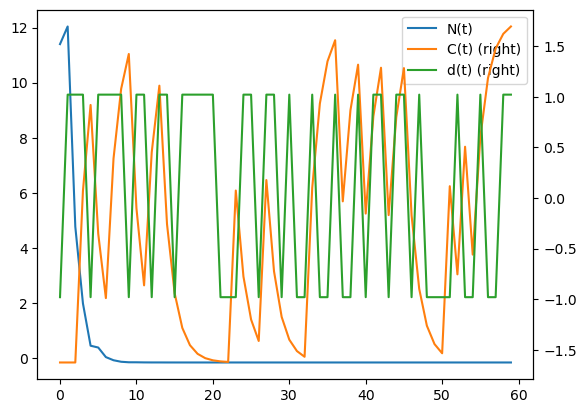

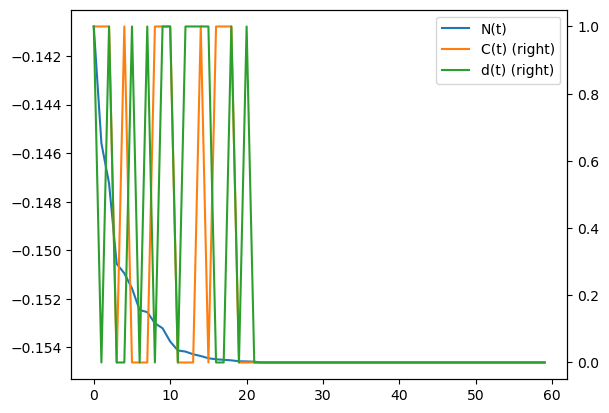

2.1.1
11.8
Figure(640x480)
Figure(640x480)
-------------------------------------------------
Running sample 1/2 on GPU 1
2024-08-07 15:59:18
sequence length: 2
mae =  0.6658040881156921
-------------------------------------------------
Running sample 2/2 on GPU 1
2024-08-07 15:59:22
sequence length: 2
mae =  0.6640214920043945
2.1.1
11.8
Figure(640x480)
Figure(640x480)
-------------------------------------------------
Running sample 1/2 on GPU 0
2024-08-07 15:59:17
sequence length: 2
mae =  0.6769092082977295
-------------------------------------------------
Running sample 2/2 on GPU 0
2024-08-07 15:59:22
sequence length: 2
mae =  0.6688144207000732
2.1.1
11.8
Figure(640x480)
Figure(640x480)
-------------------------------------------------
Running sample 1/2 on GPU 2
2024-08-07 15:59:18
sequence length: 2
mae =  0.6786360144615173
-------------------------------------------------
Running sample 2/2 on GPU 2
2024-08-07 15:59:22
sequence length: 2
mae =  0.6597752571105957


: 

In [30]:
# sample_number = 2
# final_samples = run_multiple_evaluations(
#     dataloader=test_loader,
#     imputer=diffusion_imputer,
#     training_mean=training_mean,
#     training_std=training_standard_deviation,
#     data_embedder = None,
#     num_gpus=3,
#     old_sample=[],#final_samples,
#     # min_sequence_len=2,
#     # max_sequence_len=2,
#     sample_number=sample_number,
#     scale=1
#     )

# Set the start method to 'spawn' for the notebook environment

from custom_classes_and_functions import * #wrapper_run_multiple_evaluations, create_dataloader, load_diffusion_imputer, diffusion_imputation, ModelLoop, DiffusionEmbedding, TimeEmbedding

import numpy as np
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import os
import sys

# Ensure the current directory is in sys.path

# Define your dataloader
test_loader = create_dataloader(
    test_data_counterfactuals_tensor, test_data_counterfactuals_sequence_lengths, batch_size=10000, min_seq_length=2, max_seq_length=2)

diffusion_imputer = load_diffusion_imputer("diffusion_imputer_cancer_jul23.pt")

# Assuming other necessary objects are defined (`diffusion_imputer`, `training_mean`, `training_standard_deviation`)
if __name__ == "__main__":
    diffusion_imputer =  diffusion_imputer # Initialize your imputer with appropriate parameters
    final_samples = wrapper_run_multiple_evaluations(
        dataloader=test_loader,
        imputer=diffusion_imputer,
        training_mean=training_mean,
        training_std=training_standard_deviation,
        sample_number=6,
        num_gpus=3
    )

In [71]:
#save the final samples
# torch.save(final_samples, "final_samples_cancer_jul23.pt")
# final_samples = torch.load("final_samples_cancer_jul20.pt")

In [393]:
len(final_samples)

100

In [394]:
# Calculate RMSE
rmse, rmse_median = calculate_rmse(
    final_samples, training_mean, training_standard_deviation)
print(f"RMSE: {rmse}")
print(f"RMSE using median: {rmse_median}")

RMSE: 20.37842858355978
RMSE using median: 6.875697260317596


In [372]:
# def quantile_loss(target, forecast, q: float, eval_points) -> float:
#     return 2 * torch.sum(
#         torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
#     )


# def calc_denominator(target, eval_points):
#     return torch.sum(torch.abs(target * eval_points))


# def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
#     target = target * scaler + mean_scaler
#     forecast = forecast * scaler + mean_scaler

#     quantiles = np.arange(0.05, 1.0, 0.05)
#     denom = calc_denominator(target, eval_points)
#     CRPS = 0
#     for i in range(len(quantiles)):
#         q_pred = []
#         for j in range(len(forecast)):
#             q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
#         q_pred = torch.cat(q_pred, 0)
#         q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
#         CRPS += q_loss / denom
#     return CRPS.item() / len(quantiles)


In [78]:
# sample_number = 100

In [75]:
# all_target = samples[0][1]  # input_data same for all samples (B, L, K)
# all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
# all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
# CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, training_mean, training_standard_deviation)
# print(CRPS)

In [76]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr"

In [77]:
# L = test_data.shape[1]
# K = test_data.shape[2]

# dataind = 40  # Number of samples to visualize
# start_time = 40 
# n_skip = 0  # Number of columns to skip

# plt.rcParams["font.size"] = 16
# fig, axes = plt.subplots(nrows=dataind, ncols=K - n_skip, figsize=(24.0, 6 * dataind))

# for i in range(dataind):
#     for k in range(n_skip, K):  # Start from n_skip instead of 0
#         df = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": eval_points[i, start_time:, k]
#         })
#         df = df[df.y != 0]
#         df2 = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": given_points[i, start_time:, k]
#         })
#         df2 = df2[df2.y != 0]
#         indices = df.x.astype(int).to_numpy()
#         row = i
#         col = k - n_skip  # Adjust column index for skipped columns

#         axes[row][col].plot(range(start_time, L), quantiles_imp[2][i, start_time:, k], color='g', linestyle='solid', label='median')
#         axes[row][col].fill_between(range(start_time, L), quantiles_imp[0][i, start_time:, k], quantiles_imp[4][i, start_time:, k], color='g', alpha=0.3)
#         axes[row][col].plot(df.x, df.val, color='b', marker='o', linestyle='None')
#         axes[row][col].plot(df.x, quantiles_imp[5][i, indices, k], color='r', linestyle='None', label='median', marker='x')
#         axes[row][col].plot(df.x, quantiles_imp[0][i, indices, k], color='r', linestyle='None', marker=1)
#         axes[row][col].plot(df.x, quantiles_imp[4][i, indices, k], color='r', linestyle='None', marker=1)

#         if col == 0:  # Only label the first of the remaining columns
#             axes[row][col].set_ylabel('Value')
#         if row == dataind - 1:  # Only label the last row
#             axes[row][col].set_xlabel('Time')

# # Optional: Adjust the layout for better spacing
# plt.tight_layout()
# plt.show()
